<a href="https://colab.research.google.com/github/xvxnoah/Assignment_2_DAT565/blob/main/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [6]:
# Problem 1
import tarfile
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import os
import shutil

# Problem 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

!git clone https://github.com/xvxnoah/Assignment_2_DAT565.git
%cd Assignment_2_DAT565

Cloning into 'Assignment_2_DAT565'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 6), reused 8 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 1.44 MiB | 5.75 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/Assignment_2_DAT565/Assignment_2_DAT565


### Helper functions

In [28]:
# Convert Swedish date to 'YYYY-MM-DD' format
def clean_date(date_str):
    # Mapping of Swedish month names to numerical format
    swedish_months = {
        'januari': '01',
        'februari': '02',
        'mars': '03',
        'april': '04',
        'maj': '05',
        'juni': '06',
        'juli': '07',
        'augusti': '08',
        'september': '09',
        'oktober': '10',
        'november': '11',
        'december': '12'
    }
    # date_str is expected to be in the format '28 oktober 2023'
    parts = date_str.strip().split(' ')
    if len(parts) != 3:
        return ''  # Return empty string if format is unexpected
    day, swedish_month, year = parts
    month = swedish_months.get(swedish_month.lower())
    if month is None:
        return ''  # Return empty string if month is not found
    date_formatted = f'{year}-{month}-{day.zfill(2)}'
    return date_formatted

# Parse area text to extract boarea, biarea, and number of rooms
def parse_area_text(area_text):
    area_text = area_text.replace('\u00a0', ' ').strip()
    area_text = re.sub(r'\s+', ' ', area_text)
    boarea = None
    biarea = None
    rooms = None

    # Extract boarea and biarea
    # Match patterns like '94 + 87 m²' or '94 m²'
    #area_match = re.match(r'(\d+)\s*(?:\+\s*(\d+))?\s*m²', area_text)
    area_match = re.match(r'(\d+)(\s*\+\s*(\d+))?\s*m²', area_text)
    if area_match:
        boarea = int(area_match.group(1))
        if area_match.group(3):
            biarea = int(area_match.group(3))

    # Extract number of rooms
    rooms_match = re.search(r'(\d+)\s*rum', area_text)
    if rooms_match:
        rooms = int(rooms_match.group(1))

    return boarea, biarea, rooms

# Extract listing information from a listing HTML element
def extract_listing_info(listing_html):
    listing_soup = BeautifulSoup(str(listing_html), 'html.parser')

    # Extract area information
    area_tag = listing_soup.find('div', class_='sold-property-listing__subheading sold-property-listing__area')
    if area_tag:
        area_text = area_tag.get_text(strip=True)
    else:
        area_text = ''

    boarea, biarea, rooms = parse_area_text(area_text)

    # Calculate totalarea if both boarea and biarea are available
    if boarea is not None and biarea is not None:
        totalarea = boarea + biarea
    else:
        totalarea = ''  # Leave blank as per instructions

    # Extract date of sale
    date_tag = listing_soup.find('span', class_='hcl-label hcl-label--state hcl-label--sold-at')
    if date_tag:
        date_text = date_tag.get_text(strip=True)
        date_match = re.search(r'Såld\s+(.*)', date_text)
        if date_match:
            date_str = date_match.group(1)
            date_of_sale = clean_date(date_str)
        else:
            date_of_sale = ''
    else:
        date_of_sale = ''

    # Extract address
    address_tag = listing_soup.find('h2', class_='sold-property-listing__heading qa-selling-price-title hcl-card__title')
    if address_tag:
        address = address_tag.get_text(strip=True)
    else:
        address = ''

    # Extract location
    location_tag = listing_soup.find('div', class_='sold-property-listing__location')
    if location_tag:
        location_text = location_tag.get_text()
        # Remove 'VillaVilla' if present
        if "VillaVilla" in location_text:
            location = location_text.split("VillaVilla", 1)[1].strip()
        else:
            location = location_text.strip()
        location = re.sub(r'\s+', ' ', location)
    else:
        location = ''

    # Extract plot area
    plotarea_tag = listing_soup.find('div', class_='sold-property-listing__land-area')
    if plotarea_tag:
        plotarea_text = plotarea_tag.get_text(strip=True)
        # Extract all digits, including those separated by spaces
        plotarea_digits = re.findall(r'\d+', plotarea_text)
        if plotarea_digits:
            # To remove spaces between decimals
            plotarea = int(''.join(plotarea_digits))
        else:
            plotarea = ''
    else:
        plotarea = ''

    # Extract closing price
    closingprice_tag = listing_soup.find('span', class_='hcl-text hcl-text--medium')
    if closingprice_tag:
        closingprice_text = closingprice_tag.get_text(strip=True)
        # Extract all digits, including those separated by spaces
        closingprice_digits = re.findall(r'\d+', closingprice_text)
        if closingprice_digits:
            closingprice = int(''.join(closingprice_digits))
        else:
            closingprice = ''
    else:
        closingprice = ''

    # Return the extracted information as a dictionary
    listing_info = {
        'Date of sale': date_of_sale,
        'Address': address,
        'Location': location,
        'Boarea': float(boarea) if boarea is not None else None,
        'Biarea': float(biarea) if biarea is not None else None,
        'Totalarea': float(totalarea) if totalarea != '' else None,
        'Number of rooms': float(rooms) if rooms is not None else None,
        'Plot area': float(plotarea) if plotarea != '' else None,
        'Closing price': int(closingprice) if closingprice != '' else None
    }

    return listing_info

# List all HTML files from the given root directory
def get_all_html_files(root_path):
    return Path(root_path).glob("**/*.html")

# Problem 1: Scraping house prices

In [29]:
# Extract HTML files from tar file
file_path = "kungalv_slutpriser.tar.gz"

if file_path.endswith("tar.gz"):
    tar = tarfile.open(file_path, "r:gz")
    tar.extractall()
    tar.close()
elif file_path.endswith("tar"):
    tar = tarfile.open(file_path, "r:")
    tar.extractall()
    tar.close()

# Set root folder path
html_root = Path("./kungalv_slutpriser/")

# Empty list to store data
listing_elements = []
listings=[]
listing_info=None

# Loop through each HTML file and extract data
for html_file in tqdm(list(get_all_html_files(html_root)), desc='Processing HTML files'):
    with open(html_file, encoding='utf-8') as fp:
        soup = BeautifulSoup(fp, 'html.parser')

    # Find all listings on the HTML page

    sold_results = soup.find_all('ul', class_='sold-results')
    sold_results = BeautifulSoup(str(sold_results), 'html.parser')
    listings = sold_results.find_all('li', class_='sold-results__normal-hit')

    for listing_html in listings:
        listing_info = extract_listing_info(listing_html)
        listing_elements.append(listing_info)

# Creating dataframe with scraped data
df = pd.DataFrame(listing_elements)

# Export to CSV
df.to_csv("problem1.csv", index=False)

# Delete the extracted_files folder after processing
shutil.rmtree("kungalv_slutpriser/")
print("Deleted the folder kungalv_slutpriser after processing.")

Processing HTML files: 100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

Deleted the folder kungalv_slutpriser after processing.


In [30]:
# Check the dataframe
df

,Date of sale,Address,Location,Boarea,Biarea,Totalarea,Number of rooms,Plot area,Closing price
0,2019-08-21,Olserödsgatan 16,"Olseröd, Kungälvs kommun",118.0,NaN,NaN,5.0,238.0,3875000
1,2019-08-20,Lysegården 110,"Romelanda, Kungälvs kommun",156.0,36.0,192.0,5.0,2899.0,3380000
2,2019-08-19,Vävra 433,"Hålta, Kungälvs kommun",198.0,NaN,NaN,6.0,1729.0,5300000
3,2019-08-16,Munkholmsgatan 2,"Komarken, Kungälvs kommun",137.0,73.0,210.0,7.0,893.0,5400000
4,2019-08-16,Staby 360,"Kungälv - Kärna, Kungälvs kommun",119.0,75.0,194.0,5.0,1020.0,2900000
...,...,...,...,...,...,...,...,...,...
1968,2017-08-31,Sjöhåla 170,"KÄRNA, Kungälvs kommun",124.0,72.0,196.0,5.0,2035.0,3550000
1969,2017-08-30,Duvesjön 308,"Romelanda, Kungälvs kommun",121.0,NaN,NaN,4.0,916.0,3295000
1970,2017-08-29,Hermelingatan 11,"Olseröd, Kungälvs kommun",126.0,NaN,NaN,5.0,548.0,5300000
1971,2017-08-28,Flädervägen 14,"Bohuslän, Kungälvs kommun",105.0,NaN,NaN,5.0,476.0,3450000


# Problem 2: Analyzing 2022 house sales

In [49]:
from IPython.display import display
import math
import seaborn as sns
def data_visualizer(df,max_columns=60,max_rows = 20,display_func=display,displot_kind=None):

  if not isinstance(df, pd.DataFrame):df=pd.DataFrame(df)
  pd.set_option('display.max_columns',max_columns)
  pd.set_option('display.max_rows', max_rows)
  break_line="------------------------------------------------"
  print('data sample:')
  display_func(df)
  print(break_line)
  pd.set_option('display.max_columns', None)
  pd.set_option('display.max_rows', None)
  print('data info:')
  display_func(df.info())
  print(break_line)
  # Check the general structure of the dataset
  print('data description:')
  display_func(df.describe())
  print(break_line)
  print('data nan check:')
  display_func(df.isna().sum())
  pd.set_option('display.max_columns',max_columns)
  pd.set_option('display.max_rows', max_rows)

  if displot_kind is not None:
  #  df.hist(bins=50, figsize=(20,15))
  #  plt.show()

   # Select numeric columns (integer and float types)
   numeric_columns = df.select_dtypes(include=['number']).columns

   # Calculate the square root of the number of plots to find the closest square layout
   sqrt_n = math.sqrt(len(numeric_columns))

   # Round down and round up to get possible numbers for rows and columns
   rows = math.floor(sqrt_n)
   cols = math.ceil(sqrt_n)

   # Adjust rows and columns to cover all plots
   while rows * cols < len(numeric_columns):
       if cols > rows:
           rows += 1
       else:
           cols += 1


   print(f"Rows: {rows}, Columns: {cols}")
   fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

   # Flatten the axes array for easy iteration
   axes = axes.flatten()

   # Plotting each attribute in the grid
   for i, column in enumerate(numeric_columns):
        sns.histplot(df[column], kde=displot_kind, ax=axes[i])
        axes[i].set_title(column)

   # Remove any unused subplots
   for j in range(i + 1, len(axes)):
       fig.delaxes(axes[j])

   axes.reshape(rows, cols)

   plt.tight_layout()
   plt.show()

In [32]:
# Convert 'Date of sale' to datetime
df['Date of sale'] = pd.to_datetime(df['Date of sale'], errors='coerce')

# Filter for sales in 2022
df_2022 = df[df['Date of sale'].dt.year == 2022].copy()

# Reset the index
df_2022.reset_index(drop=True, inplace=True)

data sample:


,Date of sale,Address,Location,Boarea,Biarea,Totalarea,Number of rooms,Plot area,Closing price
0,2022-06-22,Halltorpsvägen 11,"Kode, Kungälvs kommun",107.0,13.0,120.0,4.0,1119.0,4800000
1,2022-06-21,Duvesjön 351,"Romelanda, Kungälvs kommun",50.0,35.0,85.0,2.0,2418.0,1750000
2,2022-06-21,Kärnavägen 50,"Bohuslän, Kungälvs kommun",128.0,NaN,NaN,NaN,525.0,3200000
3,2022-06-21,Idrottsgatan 14,"Marstrand, Kungälvs kommun",114.0,60.0,174.0,NaN,592.0,7800000
4,2022-06-20,Äslingsvägen 10,"Tjuvkil, Kungälvs kommun",75.0,43.0,118.0,4.0,1355.0,4150000
...,...,...,...,...,...,...,...,...,...
185,2022-06-27,Silvergnejsvägen 18,"Kungälv - Gullbringa, Kungälvs kommun",179.0,NaN,NaN,5.0,2120.0,5800000
186,2022-06-27,Östra gatan 9,"Gamla Kungälv, Kungälvs kommun",325.0,81.0,406.0,10.0,852.0,10500000
187,2022-06-25,Apelvägen 10,"Diseröd, Kungälvs kommun",104.0,NaN,NaN,4.0,486.0,3275000
188,2022-06-23,Dösebacka 110,"Romelanda, Kungälvs kommun",144.0,79.0,223.0,6.0,5634.0,5780000


------------------------------------------------
data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date of sale     190 non-null    datetime64[ns]
 1   Address          190 non-null    object        
 2   Location         190 non-null    object        
 3   Boarea           187 non-null    float64       
 4   Biarea           93 non-null     float64       
 5   Totalarea        93 non-null     float64       
 6   Number of rooms  181 non-null    float64       
 7   Plot area        184 non-null    float64       
 8   Closing price    190 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 13.5+ KB


None

------------------------------------------------
data description:


,Date of sale,Boarea,Biarea,Totalarea,Number of rooms,Plot area,Closing price
count,190,187.000000,93.000000,93.000000,181.000000,184.000000,1.900000e+02
mean,2022-06-14 22:36:37.894736896,123.192513,53.849462,181.204301,4.944751,1806.826087,5.076153e+06
min,2022-01-07 00:00:00,28.000000,2.000000,65.000000,2.000000,127.000000,1.650000e+06
25%,2022-03-30 00:00:00,99.000000,21.000000,140.000000,4.000000,600.750000,4.012500e+06
50%,2022-06-07 00:00:00,121.000000,48.000000,174.000000,5.000000,1118.500000,5.000000e+06
75%,2022-08-31 18:00:00,146.000000,75.000000,211.000000,6.000000,1718.500000,5.795000e+06
max,2022-12-27 00:00:00,325.000000,174.000000,406.000000,10.000000,47500.000000,1.050000e+07
std,NaN,43.027065,37.700175,62.483660,1.405243,4108.109618,1.557399e+06


------------------------------------------------
data nan check:


,0
Date of sale,0
Address,0
Location,0
Boarea,3
Biarea,97
Totalarea,97
Number of rooms,9
Plot area,6
Closing price,0


Rows: 2, Columns: 3


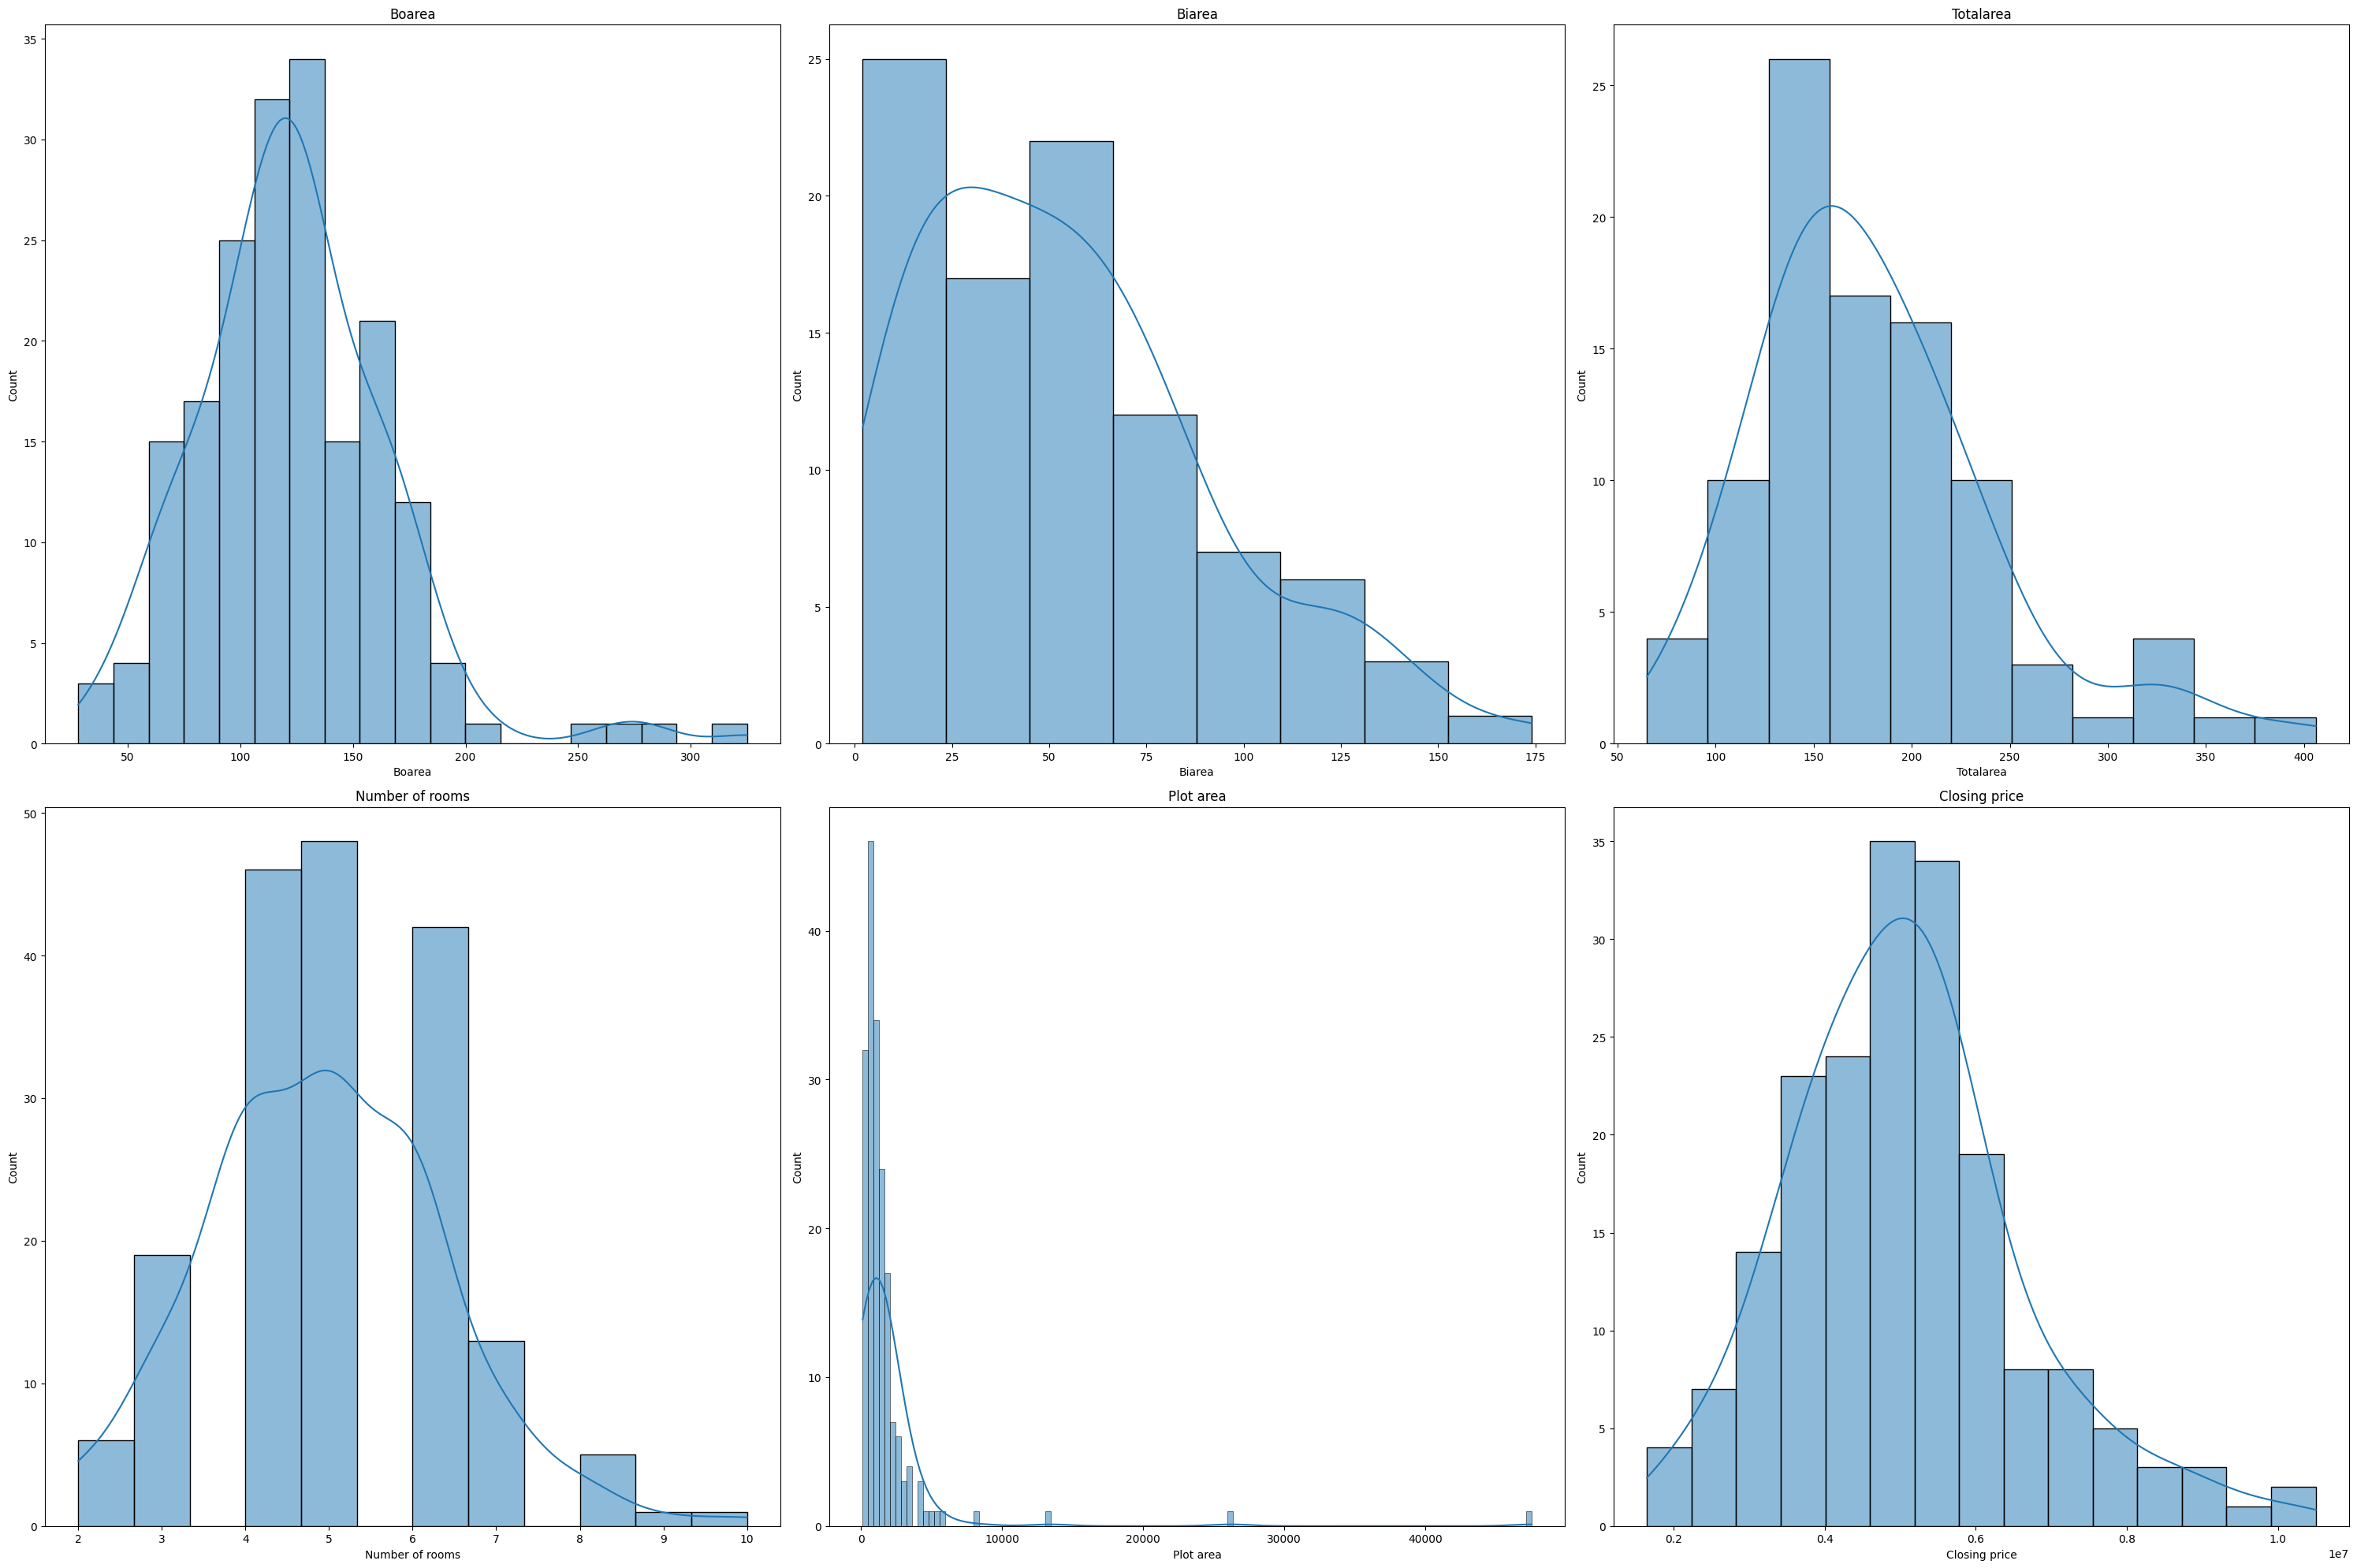

In [51]:
# Display the first few rows of the 2022 data
data_visualizer(df_2022,displot_kind='kde')

### Compute the five-number summary of the closing prices (minimum, maximum, median, first and third quartile).

In [52]:
# Ensure 'Closing price' is numeric
df_2022['Closing price'] = pd.to_numeric(df_2022['Closing price'], errors='coerce')

# Compute the five-number summary
closing_price = df_2022['Closing price'].dropna()
minimum = closing_price.min()
Q1 = closing_price.quantile(0.25)
median = closing_price.median()
Q3 = closing_price.quantile(0.75)
maximum = closing_price.max()

# Print the five-number summary
print("Five-number summary of Closing Prices in 2022:")
print(f"Minimum: {minimum}")
print(f"First Quartile (Q1): {Q1}")
print(f"Median: {median}")
print(f"Third Quartile (Q3): {Q3}")
print(f"Maximum: {maximum}")

Five-number summary of Closing Prices in 2022:
Minimum: 1650000
First Quartile (Q1): 4012500.0
Median: 5000000.0
Third Quartile (Q3): 5795000.0
Maximum: 10500000


### Construct a histogram of the closing prices. In your report, describe how you selected the number of bins (or equivalently the bin width).

In [53]:
# Calculate IQR
IQR = Q3 - Q1

# Number of observations
n = closing_price.count()

# Calculate bin width
bin_width = 2 * IQR / n**(1/3)

# Calculate number of bins
num_bins = int((maximum - minimum) / bin_width)

print(f"Calculated number of bins: {num_bins}")

Calculated number of bins: 14


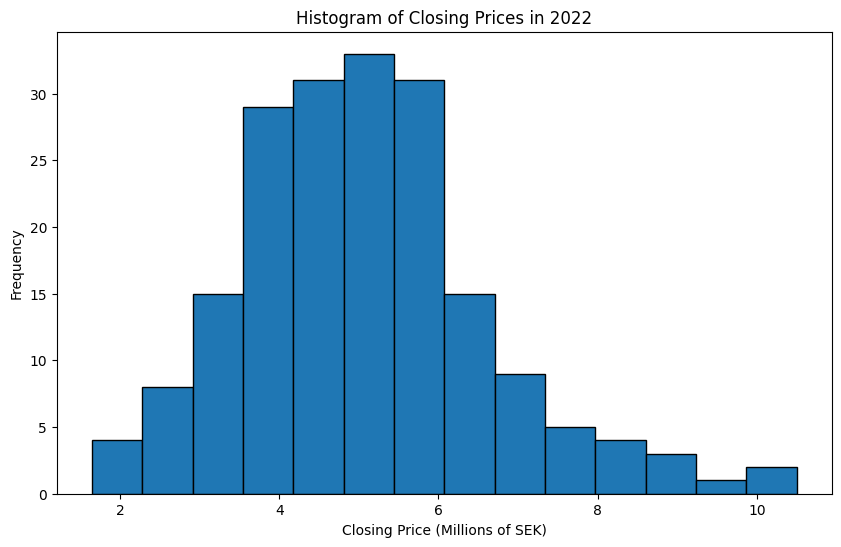

In [54]:
# Scale closing prices to millions
closing_price_millions = closing_price / 1e6

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(closing_price_millions, bins=num_bins, edgecolor='black')
plt.title('Histogram of Closing Prices in 2022')
plt.xlabel('Closing Price (Millions of SEK)')
plt.ylabel('Frequency')
plt.savefig('closing_price_histogram.pdf', format='pdf')
plt.show()

### Construct a scatter plot that shows the relationship of the closing price with the boarea of the house.

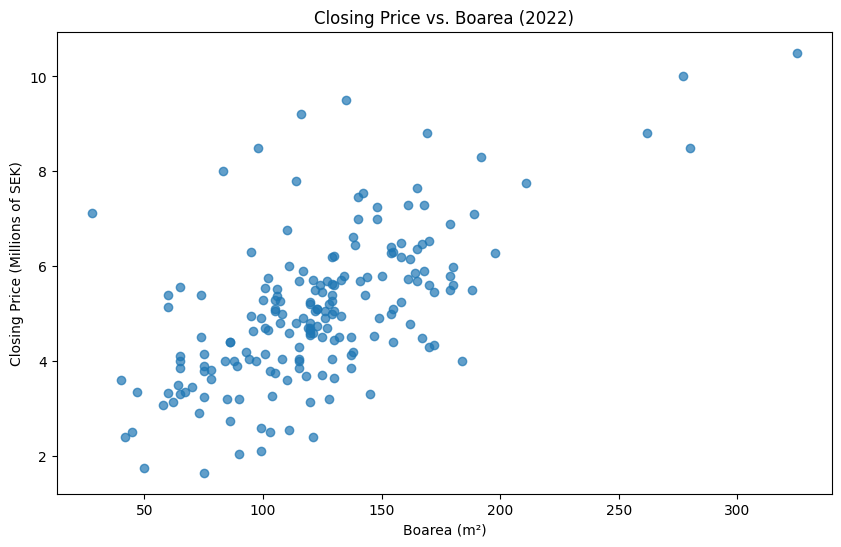

In [55]:
# Scatter plot of Closing Price vs. Boarea
scatter_data = df_2022[['Boarea', 'Closing price']].dropna()
scatter_data['Closing price (Millions)'] = scatter_data['Closing price'] / 1e6

plt.figure(figsize=(10, 6))
plt.scatter(scatter_data['Boarea'], scatter_data['Closing price (Millions)'], alpha=0.7)
plt.title('Closing Price vs. Boarea (2022)')
plt.xlabel('Boarea (m²)')
plt.ylabel('Closing Price (Millions of SEK)')
plt.savefig('closing_price_vs_boarea.pdf', format='pdf')
plt.show()

### Finally, repeat the scatter plot, but instead of showing all observations in the same color, colorize the observations by the number of rooms in the house.

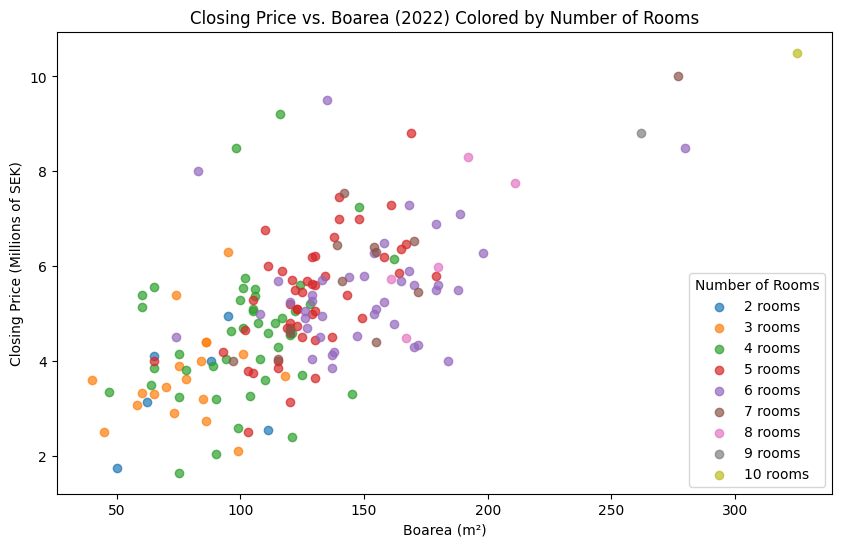

In [56]:
# Scatter plot colored by Number of Rooms
df_2022['Number of rooms'] = pd.to_numeric(df_2022['Number of rooms'], errors='coerce')
scatter_data_color = df_2022[['Boarea', 'Closing price', 'Number of rooms']].dropna()
scatter_data_color['Closing price (Millions)'] = scatter_data_color['Closing price'] / 1e6

# Get unique numbers of rooms
rooms_unique = scatter_data_color['Number of rooms'].unique()
rooms_unique.sort()

# Define a discrete color map
colors = plt.cm.tab10.colors  # Use tab10 colormap which has 10 discrete colors
color_dict = {room: colors[i % len(colors)] for i, room in enumerate(rooms_unique)}

# Plot the scatter plot
plt.figure(figsize=(10, 6))

for room in rooms_unique:
    room_data = scatter_data_color[scatter_data_color['Number of rooms'] == room]
    plt.scatter(
        room_data['Boarea'],
        room_data['Closing price (Millions)'],
        color=color_dict[room],
        label=f'{int(room)} rooms',
        alpha=0.7
    )

plt.title('Closing Price vs. Boarea (2022) Colored by Number of Rooms')
plt.xlabel('Boarea (m²)')
plt.ylabel('Closing Price (Millions of SEK)')
plt.legend(title='Number of Rooms')
plt.savefig('closing_price_vs_boarea_colored.pdf', format='pdf')
plt.show()